Intro

### **1. Initiate libraries and paths**

In [8]:
import fitz
import PyPDF2
from transformers import pipeline
import os
from glob import glob
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import re

# Folder paths for txt files
abstracts_folder = 'C:/Users/bart_/Documents/Ethical_AI/Assignment/Abstracts'
pdf_folder = 'C:/Users/bart_/Documents/Ethical_AI/Assignment/Literature'

### **2. Create word cloud**

In [3]:
# Load text from all txt files
abstract_texts = []
for file in glob(os.path.join(abstracts_folder, "*.txt")):
    with open(file, 'r', encoding='utf-8') as f:
        abstract_texts.append(f.read())

# Print the number of abstracts read
print(f"Number of abstracts read: {len(abstract_texts)}")

# Join all abstracts into one text for word cloud generation
all_abstracts_text = " ".join(abstract_texts)

Number of abstracts read: 86


In [9]:
# Use the same processing rules as WordCloud for tokenization and stopword removal
def process_text_for_wordcloud(text, stopwords):
    words = text.lower().split()
    # Remove stopwords and non-alphabetic tokens
    cleaned_words = [word.strip(".,!?\"':;()[]{}") for word in words if word not in stopwords]
    return cleaned_words

# Process the text using WordCloud's stopwords
stopwords = set(STOPWORDS)
processed_tokens = process_text_for_wordcloud(all_abstracts_text, stopwords)

# Count word frequencies
word_counts = Counter(processed_tokens)

# Get the top 25 words
top_25_words = word_counts.most_common(25)

# Print the top 25 words
print("Top 25 words in the word cloud:")
for word, count in top_25_words:
    print(f"{word}: {count}")
    

Top 25 words in the word cloud:
insurance: 329
data: 184
learning: 157
models: 154
claims: 137
risk: 136
model: 131
ai: 121
paper: 92
machine: 88
claim: 82
algorithms: 73
techniques: 71
methods: 68
underwriting: 68
accuracy: 67
neural: 61
used: 57
fraud: 54
industry: 51
pricing: 50
study: 48
damage: 48
performance: 48
processing: 47


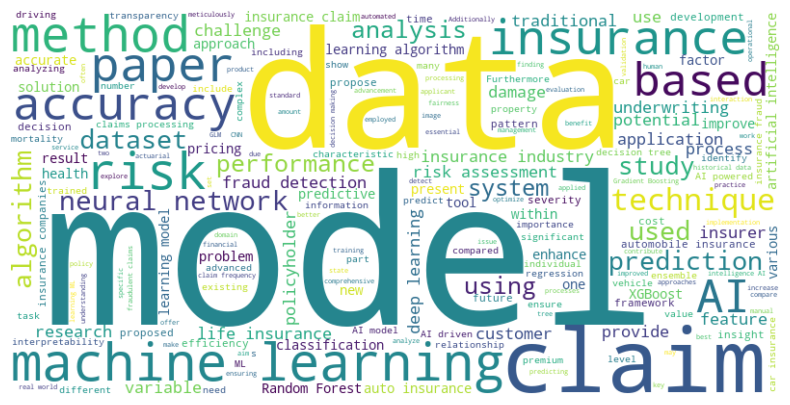

In [6]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_abstracts_text)

# Display the word cloud
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### **3. Word counter on words of interest**

In [4]:
# Initiate empty dict
pdf_texts = {}

# Use glob to recursively find all PDFs in subfolders
for file in glob(os.path.join(pdf_folder, "**", "*.pdf"), recursive=True):
    pdf_text = ""
    with open(file, 'rb') as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        for page_num in range(len(pdf_reader.pages)):
            pdf_text += pdf_reader.pages[page_num].extract_text()
    
    # Extract the subfolder name
    subfolder_name = os.path.basename(os.path.dirname(file))

    # Store
    pdf_texts[(os.path.basename(file), subfolder_name)] = pdf_text

Invalid parent xref., rebuild xref


In [ ]:
# List of insurance-related words
interest_words = [
    'neural network'
    , 'gbm'
    , 'xgboost'
    , 'random forest'
    , 'decision tree'
    , 'tree'
    , 'logistic'
    , 'linear regression'
    , 'explainability'
    , 'explainable'
    , 'xai'
    , 'fairness'
    , 'lime'
    , 'shapley'
    , 'shap'
    , 'partial dependence plots'
    , 'feature importance'
    , 'interpretability']

In [6]:
# Count words in each PDF text
pdf_word_counts = []
for (filename, subfolder), text in pdf_texts.items():
    word_count = Counter(word.lower() for word in text.split())
    count_data = {word: word_count[word] for word in interest_words}
    
    # Add the filename and subfolder name to the count data
    count_data['title'] = filename
    count_data['subdomain'] = subfolder
    
    pdf_word_counts.append(count_data)

# Convert to DataFrame for visualization
df_word_counts = pd.DataFrame(pdf_word_counts)

In [7]:
pdf_word_counts = []
for (filename, subfolder), text in pdf_texts.items():
    # Convert text to lowercase for case-insensitive matching
    text_lower = text.lower()
    count_data = {'title': filename, 'subfolder': subfolder}
    
    # Count occurrences of each individual word and phrase
    for term in interest_words:
        # If the term contains spaces, it's a phrase
        if " " in term:
            # Count the phrase using regex with word boundaries
            count = len(re.findall(r'\b' + re.escape(term) + r'\b', text_lower))
        else:
            # Count single words with a simpler method
            count = text_lower.split().count(term)
        
        count_data[term] = count
    
    pdf_word_counts.append(count_data)

# Convert to DataFrame for visualization
df_word_counts = pd.DataFrame(pdf_word_counts)

In [8]:
df_word_counts

,title,subfolder,neural network,gbm,xgboost,random forest,explainability,xai,fairness,lime,shapley,interpretability
0,Advanced+AI+Techniques+for+Optimizing+Claims+M...,Claims,0,0,0,1,3,0,5,0,0,3
1,AI-Enhanced+Claims+Processing+in+Insurance.pdf,Claims,0,0,0,0,1,1,3,0,0,2
2,AI-Powered+Techniques+for+Claims+Triage+in+Pro...,Claims,0,0,0,0,2,0,4,0,0,0
3,Automated vehicle damage classification.pdf,Claims,1,0,0,0,0,0,1,0,0,0
4,Automatic damaged vehicle estimator using enha...,Claims,6,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
85,Improving the Accuracy and Transparency of Und...,Underwriting,1,0,0,0,1,0,5,0,2,1
86,Machine+Learning+Algorithms+for+Automated+Unde...,Underwriting,0,4,0,0,6,25,9,3,1,2
87,Risk prediction in life insurance industry usi...,Underwriting,10,0,0,0,0,0,0,0,0,0
88,Smart_Underwriting_System_An_Intelligent_Decis...,Underwriting,0,0,0,0,0,0,0,0,0,0


In [9]:
df_word_counts.to_csv('C:/Users/bart_/Documents/Ethical_AI/Assignment/chk_word_counts.csv')